# Sección A. PGR

## Descripción general de la tabla

https://datos.cdmx.gob.mx/dataset/carpetas-de-investigacion-fgj-de-la-ciudad-de-mexico

Información actualizada de las carpetas de investigación de la Fiscalia General de Justicia (FGJ) de la Cdmx apartir de **enero de 2016**.

Las variables contenidas son Carpetas de Investigación de delitos a nivel calle de la FGJ por FIscalía, Agenica, Unidad de Investigación (UI), fecha de apertura de la carpeta de investigación, delito, categoría de delito, calle, colonia, alcaldía, coordenadas, mes y año.

Actualizaciones mensuales (**última actualización 29 de julio de 2020**) 

**Nota**
1. Pueden presentarse diferencias en lo reportado del Secretariado, ya que el reporte mensual se basa en criterios de homologación del resto de los estados, y solo considera delitos del fuero común excluyendo:
    * incompetencias por tipo de fuero
    * incompetencias por territorio
    * hechos no delictivos
    * denuncias de hechos
    * hechos delicitivos cometidos por menores de edad
    

## Preguntas

1. ¿Qué pruebas identificarías para asegurar la calidad de estos datos? No es necesario
hacerlas. Sólo describe la prueba y qué te dice cada una.

2. ¿Cuántos delitos registrados hay en la tabla? ¿Qué rango de tiempo consideran los
datos?
3. ¿Cómo se distribuye el número de delitos en la CDMX? ¿Cuáles son los 5 delitos más
frecuentes?

4. Identifica los delitos que van a la alza y a la baja en la CDMX en el último año (ten
cuidado con los delitos con pocas ocurrencias).

5. ¿Cuál es la alcaldía que más delitos tiene y cuál es la que menos?.¿Por qué crees que sea
esto?

6. Dentro de cada alcaldía, cuáles son las tres colonias con más delitos

7. ¿Existe alguna tendencia estacional en la ocurrencia de delitos (mes, semana, día de la
semana, quincenas)?

8. ¿Cuáles son los delitos que más caracterizan a cada alcaldía? Es decir, delitos que
suceden con mayor frecuencia en una alcaldía y con menor frecuencia en las demás.

9. Calcula el número de homicidios dolosos por cada 100 mil habitantes anual para cada
Área Geoestadística Básica (AGEB) del INEGI. (hint: no importa que el dato de
población no esté actualizado).

    9.1. Pinta un mapa con este indicador. Describe los resultados.

10. ¿Cómo diseñarías un indicador que midiera el nivel “inseguridad”? Diséñalo al nivel de
desagregación que te parezca más adecuado (ej. manzana, calle, AGEB, etc.).

11. Con alguna de las medidas de crimen que calculaste en los incisos anteriores, encuentra
patrones de concentración geográfica de delitos (hint: puedes usar algoritmos de
Machine Learning no supervisados).
    11.1. ¿Qué caracteriza a cada punto de concentración de delitos y qué tienen en
común?

12. Toma los delitos clasificados como “Robo a pasajero a bordo de transporte público con
y sin violencia”. ¿Cuáles son las ruta de transporte público donde más ocurren estos
delitos?

# Librerías y datos

In [300]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import re
from pandas import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame

import multiprocessing
from os import getpid
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

import pickle

%matplotlib inline

In [2]:
pgr = pd.read_csv('data/48fcb848-220c-4af0-839b-4fd8ac812c0f', delimiter = ",")

/home/abraxas/venv/opi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## ¿Qué pruebas identificarías para asegurar la calidad de estos datos? No es necesario hacerlas. Sólo describe la prueba y qué te dice cada una.

1. Confiabilidad

    a.  Precisión: 

        * API checar si las coordenadas corresponden a domiclio 
        * Coordenadas dentro de la ciudad de México

        Mostrar el estado verdadero de los datos através de

        * Cruce de información de reporte de plataforma contra mismos agrupados: The data representation (or value) reflects well the actual state of the source information (+-10% variación de los resultados, ya que no coinciden al 100% por lo comentado en la **Nota** inicial)
        * Buscar otras fuentes de datos que tengan sentido entre las distintas fuentes (INEGI, Servicio de transporte úblico)

        Evitar ambigüedad en los datos
        * Dependiendo del objetivo la información deberá de tener una tasa baja de datos vacíos

    b. Integridad
    
        * Se respetan los catálogos de datos (categoría de delito, fiscalía, agencia, unidad de investigación):The data format is clear and meets the criteria
        * Tipos de datos
        * Rangos aceptables para variables numéricas 
        * Si hay transformaciones de variables como columnas deben de tener completo sentido

        * fechas de inicio de carpeta >= fecha de hechos
        * Id's únicos de delitos
        * Coordenadas corresponden al domicilio
        * Coordenadas dentro del país
        * Outliers
        * Fechas de hechos >= 2016 
    
2. Leegibilidad
    Los datos (contenido, formato, etc) deben estar de preferencia limpios y entendibles, en especial si es que no vienen tan limpios.
        * Existencia de diccionario
        * Existencia de catálogos

Clasificación basada en:

https://translate.google.com/translate?hl=en&sl=es&u=https://blog.powerdata.es/el-valor-de-la-gestion-de-datos/bid/368784/introducci-n-a-la-calidad-de-datos-definici-n-control-y-beneficios&prev=search&pto=aue

## ¿Cuántos delitos registrados hay en la tabla? ¿Qué rango de tiempo consideran los datos?

In [4]:
pgr['fecha_hechos'] = pgr['fecha_hechos'].apply(lambda x: x if not type(x) == str else datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
pgr['fecha_inicio'] = pgr['fecha_inicio'].apply(lambda x: x if not type(x) == str else datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))

In [5]:
print(f'Total de delitos registrados: {len(pgr)}\n', f'Fecha mínima para hechos: {pgr.fecha_hechos.min()}\n',
      f'Fecha mínima para inicios de carpeta: {pgr.fecha_inicio.min()}')

Total de delitos registrados: 1168250
 Fecha mínima para hechos: 1906-06-02 19:00:00
 Fecha mínima para inicios de carpeta: 2016-01-01 01:35:06


# Exploración para limpieza de datos

In [6]:
pgr.shape

(1168250, 20)

#### Tipo de datos

In [7]:
pgr.dtypes.to_frame()

,0
_id,int64
ao_hechos,float64
mes_hechos,object
fecha_hechos,datetime64[ns]
ao_inicio,int64
mes_inicio,object
fecha_inicio,datetime64[ns]
delito,object
fiscalia,object
agencia,object


In [8]:
pgr.isnull().sum()

_id                           0
ao_hechos                   433
mes_hechos                  433
fecha_hechos                433
ao_inicio                     0
mes_inicio                    0
fecha_inicio                  0
delito                        0
fiscalia                      2
agencia                       0
unidad_investigacion        227
categoria_delito              0
calle_hechos               2969
calle_hechos2            709215
colonia_hechos            47432
alcaldia_hechos            3177
competencia             1064079
longitud                  46464
latitud                   46464
tempo                   1168250
dtype: int64

**NULOS**
* Fecha_hechos
    Imputar nulos de fechas con 1900-01-01 (asegurarnos que no hay registros con este valor)

* Fiscalia, unidad_investigacion, calle_hechos, calle_hechoS2, colonia_hechos, alcaldia_hechos, competencia
    Imputar con "SIN INFORMACIÓN"
    
* Longitud/latitud
    No imputar

* Tempo
    Eliminar

In [9]:
pgr['mes_hechos'] = pgr.fecha_hechos.dt.month
pgr['ao_hechos'] = pgr.fecha_hechos.dt.year

In [10]:
pgr['mes_inicio'] = pgr.fecha_inicio.dt.month
pgr['ao_inicio'] = pgr.fecha_inicio.dt.year

In [11]:
col_str = ['delito', 'fiscalia', 'agencia','unidad_investigacion', 'categoria_delito', 'calle_hechos',
           'calle_hechos2', 'colonia_hechos', 'alcaldia_hechos', 'competencia']
col_int = ['_id', 'ao_hechos', 'mes_hechos','ao_inicio','mes_inicio']
col_dt = ['fecha_hechos','fecha_inicio']
col_float = ['longitud', 'latitud', 'tempo']

In [12]:
#Asegurarme que no olvido o me sobra alguna variable
print(len(set(col_dt+col_float+col_int+col_str))/len(pgr.columns),
      len(col_dt+col_float+col_int+col_str)/len(pgr.columns))

1.0 1.0


In [13]:
col_str

['delito',
 'fiscalia',
 'agencia',
 'unidad_investigacion',
 'categoria_delito',
 'calle_hechos',
 'calle_hechos2',
 'colonia_hechos',
 'alcaldia_hechos',
 'competencia']

In [14]:
pgr[col_str] = pgr[col_str].astype(str)

In [15]:
col_float

['longitud', 'latitud', 'tempo']

In [16]:
pgr[col_float] = pgr[col_float].astype(float)

In [17]:
pgr[col_int] = pgr[col_int].astype(pd.Int32Dtype())

In [18]:
pgr.dtypes.to_frame()

,0
_id,Int32
ao_hechos,Int32
mes_hechos,Int32
fecha_hechos,datetime64[ns]
ao_inicio,Int32
mes_inicio,Int32
fecha_inicio,datetime64[ns]
delito,object
fiscalia,object
agencia,object


#### Categorías, rangos y outliers

* Latitud (-90,90)
* Longitud (-180,180)
* Fecha inicio >= 2016
* Fecha hechos <= fecha_inicio
* Tempo >= 0

In [19]:
pgr[['latitud','longitud','ao_hechos','ao_inicio','tempo']].describe()

,latitud,longitud,ao_hechos,ao_inicio,tempo
count,1.121786e+06,1.121786e+06,1.167817e+06,1.168250e+06,0.0
mean,1.938754e+01,-9.913727e+01,2.017964e+03,2.018112e+03,NaN
std,6.966439e-02,5.970430e-02,1.734185e+00,1.422001e+00,NaN
min,1.909535e+01,-1.002319e+02,1.906000e+03,2.016000e+03,NaN
25%,1.934020e+01,-9.917550e+01,2.017000e+03,2.017000e+03,NaN
50%,1.939013e+01,-9.914218e+01,2.018000e+03,2.018000e+03,NaN
75%,1.943771e+01,-9.910001e+01,2.019000e+03,2.019000e+03,NaN
max,1.958333e+01,-9.894686e+01,2.021000e+03,2.021000e+03,NaN


In [20]:
pgr[pgr.ao_inicio<2016]

,_id,ao_hechos,mes_hechos,fecha_hechos,ao_inicio,mes_inicio,fecha_inicio,delito,fiscalia,agencia,unidad_investigacion,categoria_delito,calle_hechos,calle_hechos2,colonia_hechos,alcaldia_hechos,competencia,longitud,latitud,tempo


In [21]:
len(pgr[(pgr.fecha_hechos.dt.date>pgr.fecha_inicio.dt.date)])/len(pgr)

8.38861545046009e-05

In [22]:
len(pgr._id)/len(pgr)

1.0

* Las coordenadas entran dentro del rango

* Inicio de carpetas si es apartir de 2016

* Fecha hechos > fecha inicio (sin contar diferencia de horas) son datos que no cumplen con data accuracy ya que no pudo haberse cometido délito después de iniciar la carpeta de investigación. ¿O sí?

**Beredicto**: Son eliminados 0.00003886%

* _id si es un identificador para cada carpeta de investigación

In [23]:
pgr = pgr[~(pgr.fecha_hechos.dt.date>pgr.fecha_inicio.dt.date)].reset_index(drop=True).copy()

In [24]:
pgr.shape

(1168152, 20)

In [25]:
pgr.columns

Index(['_id', 'ao_hechos', 'mes_hechos', 'fecha_hechos', 'ao_inicio',
       'mes_inicio', 'fecha_inicio', 'delito', 'fiscalia', 'agencia',
       'unidad_investigacion', 'categoria_delito', 'calle_hechos',
       'calle_hechos2', 'colonia_hechos', 'alcaldia_hechos', 'competencia',
       'longitud', 'latitud', 'tempo'],
      dtype='object')

In [26]:
pgr.drop(['tempo'],axis=1,inplace=True)

In [27]:
pgr.columns

Index(['_id', 'ao_hechos', 'mes_hechos', 'fecha_hechos', 'ao_inicio',
       'mes_inicio', 'fecha_inicio', 'delito', 'fiscalia', 'agencia',
       'unidad_investigacion', 'categoria_delito', 'calle_hechos',
       'calle_hechos2', 'colonia_hechos', 'alcaldia_hechos', 'competencia',
       'longitud', 'latitud'],
      dtype='object')

In [28]:
ident = ['id']
var_cont = ['longitud', 'latitud']
var_disc = ['ao_hechos','ao_inicio',]
var_cat  = ['mes_hechos','mes_inicio','delito', 'fiscalia', 'agencia','unidad_investigacion', 'categoria_delito', 
            'calle_hechos','calle_hechos2', 'colonia_hechos', 'alcaldia_hechos', 'competencia']
var_dts  = ['fecha_hechos','fecha_inicio']

In [29]:
#Asegurarme que no olvido o me sobra alguna variable
print(len(set(ident+var_cont+var_disc+var_cat+var_dts))/len(pgr.columns),
      len(ident+var_cont+var_disc+var_cat+var_dts)/len(pgr.columns))

1.0 1.0


In [30]:
for columna in var_cat:
    print(columna,'*'*10,pgr[columna].value_counts(1),'-'*5,len(pgr[columna].unique()))

mes_hechos ********** 1     0.093322
2     0.090523
10    0.087744
3     0.084797
8     0.084068
11    0.082795
9     0.082279
5     0.080927
7     0.080018
12    0.079815
6     0.078339
4     0.075373
Name: mes_hechos, dtype: Float64 ----- 13
mes_inicio ********** 2     0.092859
1      0.09252
10    0.088795
3     0.084758
8     0.084506
11    0.082475
9     0.081632
7     0.080881
12     0.07905
5     0.078988
6     0.078079
4     0.075458
Name: mes_inicio, dtype: Float64 ----- 12
delito ********** VIOLENCIA FAMILIAR                                                        9.956838e-02
FRAUDE                                                                    6.042878e-02
ROBO DE OBJETOS                                                           5.900174e-02
ROBO A NEGOCIO SIN VIOLENCIA                                              5.595419e-02
AMENAZAS                                                                  5.243068e-02
                                                           

# Cuestionario

## ¿Cómo se distribuye el número de delitos en la CDMX? ¿Cuáles son los 5 delitos más frecuentes?

pgr = pgr.drop(columns=['n'])

In [31]:
pgr['num_delitos'] = 1

In [32]:
group_delito = pgr[['num_delitos','delito']].groupby(['delito']).sum().sort_values(by='num_delitos',ascending=False)/len(pgr)*100

### Respuesta

In [33]:
group_delito

,num_delitos
delito,
VIOLENCIA FAMILIAR,9.956838
FRAUDE,6.042878
ROBO DE OBJETOS,5.900174
ROBO A NEGOCIO SIN VIOLENCIA,5.595419
AMENAZAS,5.243068
...,...
SECUESTRO,0.000086
ASOCIACION DELICTUOSA,0.000086
"PROCREACION ASISTIDA, INSEMINACION ARTIFICIAL Y ESTERILIZACION FORZADA",0.000086


## Identifica los delitos que van a la alza y a la baja en la CDMX en el último año (ten cuidado con los delitos con pocas ocurrencias).

In [34]:
fecha_final = datetime.today()
fecha_inicial = fecha_final-timedelta(weeks=52)

In [35]:
pgr_lastyear = pgr[(pgr.fecha_hechos>=fecha_inicial) & (pgr.fecha_hechos<=fecha_final)].copy()

In [36]:
lista_fechas = pd.date_range(fecha_inicial,fecha_final,freq='D').strftime('%Y-%m').unique().tolist()

### Mes-anio

In [37]:
pgr_lastyear = pgr_lastyear[~pgr_lastyear.fecha_hechos.isnull()].copy()

pgr_lastyear['mes_anio_hechos'] = pgr_lastyear['fecha_hechos'].apply(lambda x: x.strftime('%Y-%m'))
pgr_lastyear['semana_anio_hechos'] = pgr_lastyear['fecha_hechos'].apply(lambda x: x.strftime('%Y-%WS'))

In [38]:
group_delito_lastyear = pgr_lastyear[['num_delitos','delito']].groupby(['delito']).sum().sort_values(by='num_delitos',ascending=False)
group_delito_lastyear.reset_index(inplace=True)
group_delito_lastyear['pct_delitos'] = group_delito_lastyear['num_delitos']/len(pgr_lastyear)*100

In [39]:
def crecimiento(periodo,data):
    if periodo == 'semanas':
        columna = 'semana_anio_hechos'
    elif periodo == 'mes':
        columna =  'mes_anio_hechos'
    agrupado = data[[columna,'delito','num_delitos']].groupby([columna,'delito']).sum().reset_index()
    result_delito = pd.DataFrame()
    for delito in agrupado.delito.unique():
        agrupado_delito = agrupado[agrupado.delito==delito].copy()
        aux = [x for x in lista_fechas if x not in agrupado_delito[columna].unique()]
        agrupado_delito = agrupado_delito.append(pd.DataFrame({columna:aux,'delito':delito,'num_delitos':[0]*len(aux)})).sort_values(by=columna).reset_index(drop=True)
        #agrupado_delito['diff_'] = (agrupado_delito['num_delitos']-agrupado_delito['num_delitos'].shift(1))
        #agrupado_delito.dropna(inplace=True)
        x = np.arange(0,len(agrupado_delito))
        y=np.array(agrupado_delito.num_delitos)
        z = np.polyfit(x,y,1)
        result_delito = result_delito.append(pd.DataFrame({'delito':[delito],'m':[z[0]]}))
    return result_delito
                                    

In [40]:
result_delito = crecimiento('semanas',pgr_lastyear)

In [41]:
result_delito

,delito,m
0,AMENAZAS,0.761329
0,CONTRA LA INTIMIDAD SEXUAL,0.144573
0,DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...,0.232382
0,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL,0.113933
0,DDH RELACIONADAS,0.004311
...,...,...
0,HOMICIDIO CULPOSO POR INSTRUMENTO PUNZO CORTANTE,0.002198
0,ROBO A PASAJERO EN TREN LIGERO SIN VIOLENCIA,0.002198
0,HOMICIDIO CULPOSO,0.015385
0,PERDIDA DE LA VIDA POR DERRUMBE,0.028571


In [42]:
result_delito = result_delito.merge(group_delito_lastyear,on=['delito'])

In [43]:
result_delito['m*pct'] = result_delito["m"]*result_delito["pct_delitos"]

In [44]:
result_delito = result_delito.sort_values(by='m*pct',ascending = False)

In [45]:
result_delito_crec = result_delito.head(10)
result_delito_decrec = result_delito.tail(10)

### Resultados

#### Crecimiento

In [46]:
result_delito_crec

,delito,m,num_delitos,pct_delitos,m*pct
40,VIOLENCIA FAMILIAR,2.263264,20605,15.247490,34.509094
0,AMENAZAS,0.761329,10180,7.533096,5.735163
27,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,1.221093,6175,4.569437,5.579709
139,ROBO DE ACCESORIOS DE AUTO,0.728208,5531,4.092884,2.980470
29,ROBO DE OBJETOS,0.362442,5938,4.394059,1.592590
6,FRAUDE,0.185696,8383,6.203334,1.151933
20,ROBO A NEGOCIO SIN VIOLENCIA,0.442267,2707,2.003152,0.885929
150,ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO,0.232946,3319,2.456026,0.572122
121,ROBO A NEGOCIO CON VIOLENCIA,0.548194,1382,1.022666,0.560620
33,ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...,0.169005,3509,2.596624,0.438842


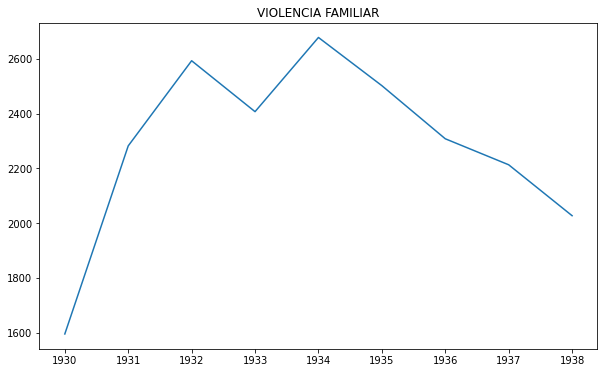

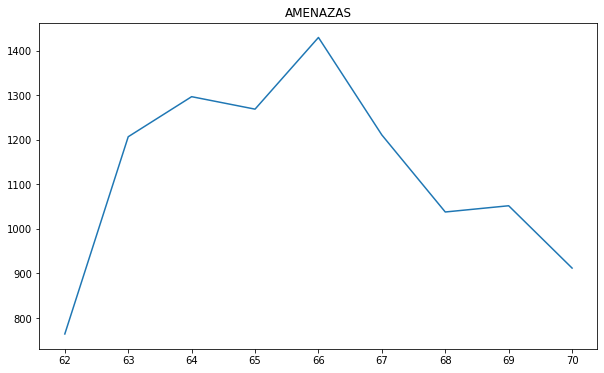

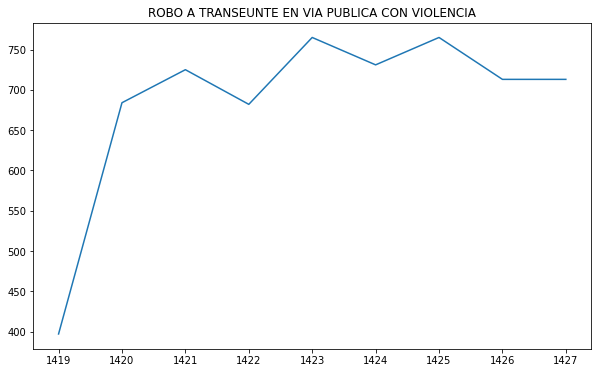

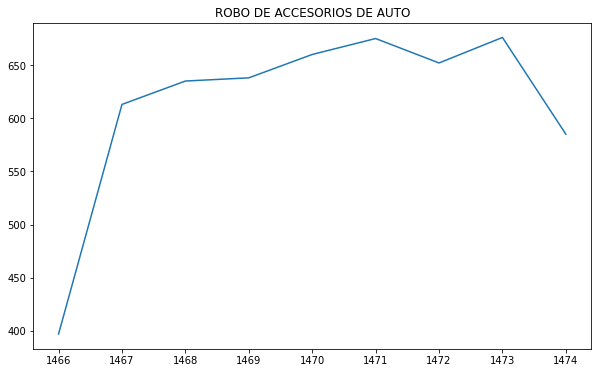

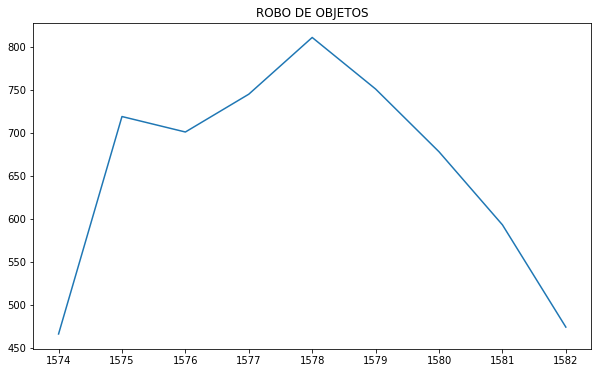

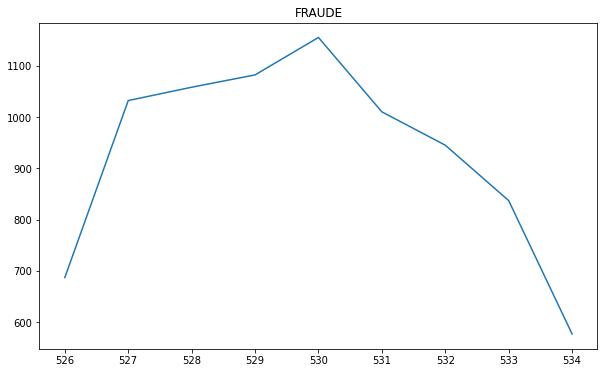

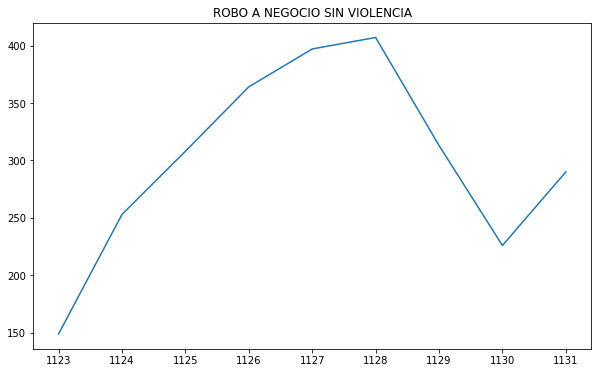

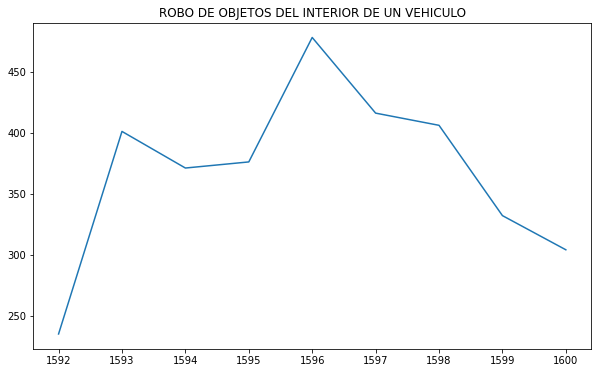

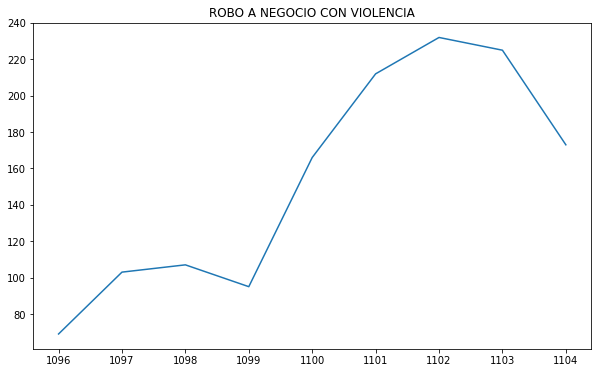

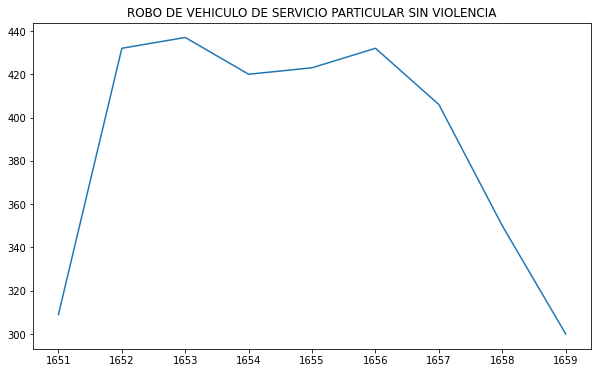

In [289]:
agrupado_delito_mesanio = pgr_lastyear.groupby(['delito','mes_anio_hechos'])[['num_delitos']].sum().reset_index()

for delito in result_delito_crec.delito.tolist():
    fig = plt.figure(figsize=(10,6))
    plt.plot(agrupado_delito_mesanio[agrupado_delito_mesanio.delito == delito].num_delitos)
    plt.title(delito)
    plt.show()

#### Decrecimiento

In [47]:
result_delito_decrec

,delito,m,num_delitos,pct_delitos,m*pct
153,"ROBO S/V DENTRO DE NEGOCIOS, AUTOSERVICIOS, CO...",-0.043584,715,0.529093,-0.023060
99,NEGACION DEL SERVICIO PUBLICO,-0.084052,375,0.277496,-0.023324
32,ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...,-0.023383,1425,1.054485,-0.024657
90,LA ADMINISTRACION DE JUSTICIA,-0.078204,548,0.405514,-0.031713
22,ROBO A NEGOCIO SIN VIOLENCIA POR FARDEROS (TIE...,-0.215933,715,0.529093,-0.114249
72,DESPOJO,-0.080637,2653,1.963193,-0.158306
19,ROBO A NEGOCIO CON VIOLENCIA POR FARDEROS (TIE...,-0.290317,757,0.560172,-0.162627
17,"PRODUCCIÓN, IMPRESIÓN, ENAJENACIÓN, DISTRIBUCI...",-0.193437,1495,1.106285,-0.213996
42,ABUSO DE CONFIANZA,-0.248442,2018,1.493299,-0.370998
13,NARCOMENUDEO POSESION SIMPLE,-0.246976,2596,1.921013,-0.474445


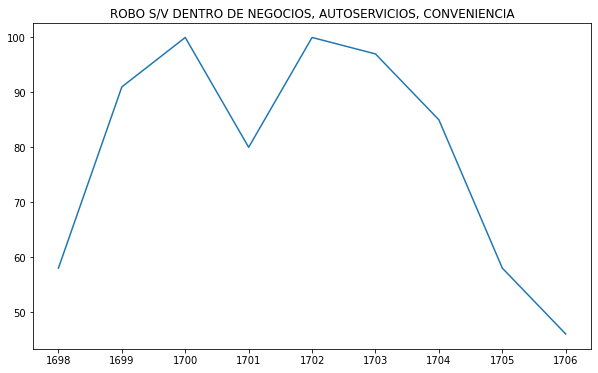

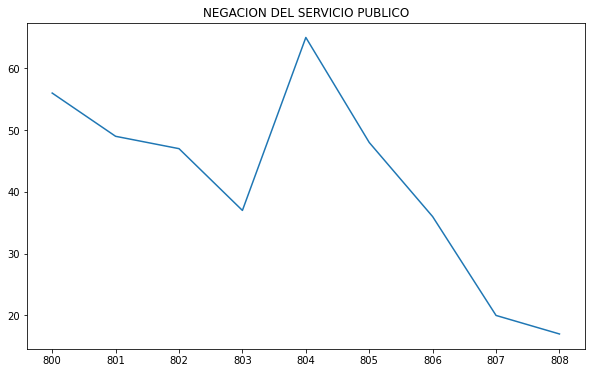

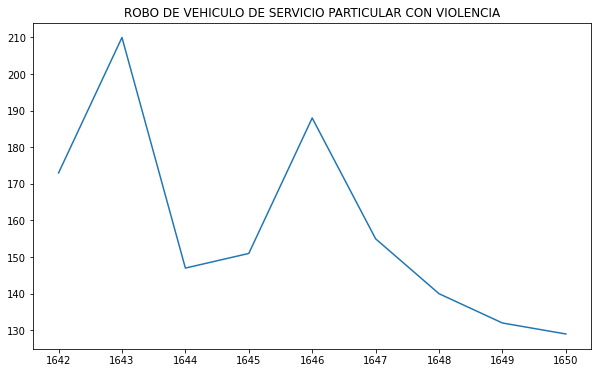

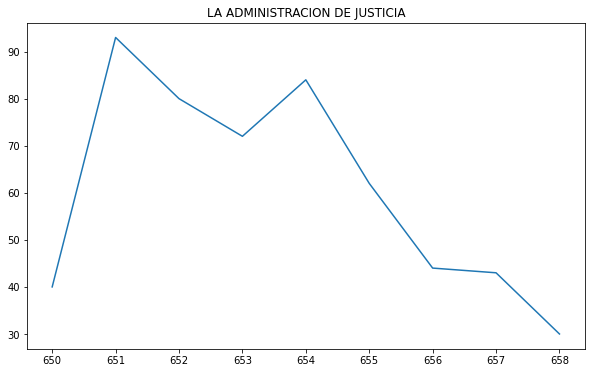

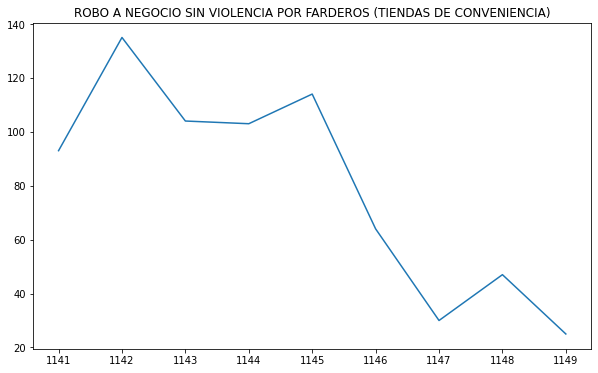

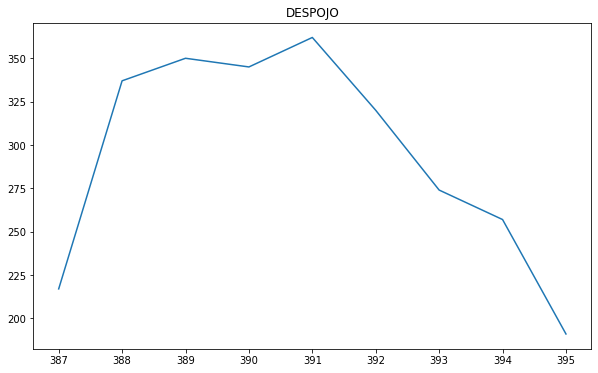

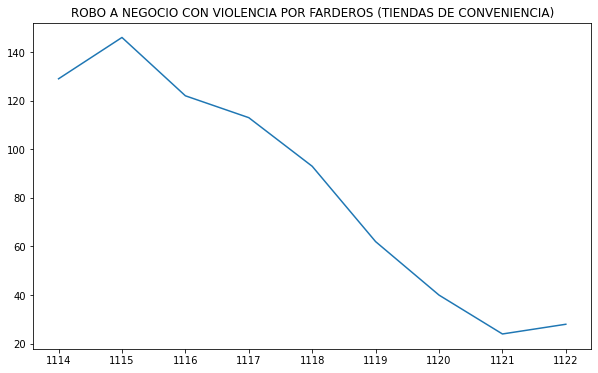

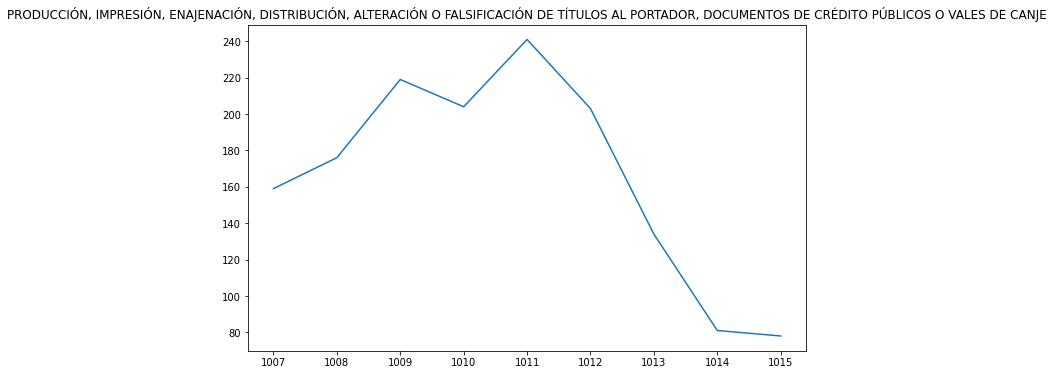

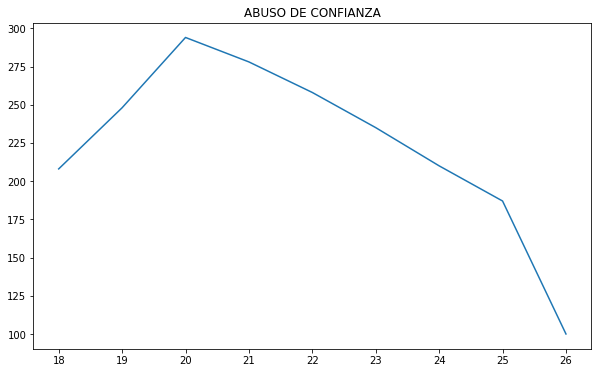

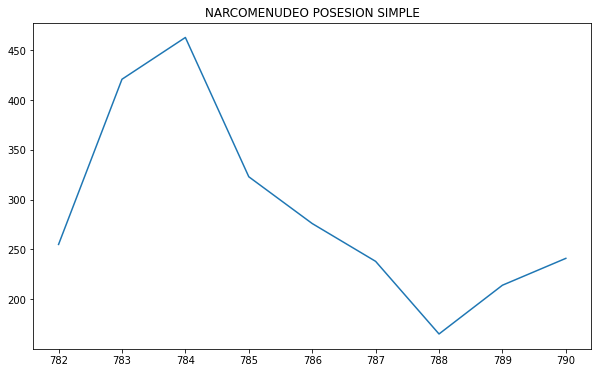

In [290]:
agrupado_delito_mesanio = pgr_lastyear.groupby(['delito','mes_anio_hechos'])[['num_delitos']].sum().reset_index()

for delito in result_delito_decrec.delito.tolist():
    fig = plt.figure(figsize=(10,6))
    plt.plot(agrupado_delito_mesanio[agrupado_delito_mesanio.delito == delito].num_delitos)
    plt.title(delito)
    plt.show()

for delito in pgr_lastyear.delito.unique():
    aux = pgr_lastyear[pgr_lastyear.delito == delito].groupby(['mes_anio_hechos'])[['num_delitos']].sum()
    fig = plt.figure(figsize=(10,6))
    plt.plot(aux)
    plt.title(delito)
    plt.show()

## ¿Cuál es la alcaldía que más delitos tiene y cuál es la que menos?.¿Por qué crees que sea esto?

### Resultados

In [51]:
pgr.groupby(['alcaldia_hechos']).sum()[['num_delitos']].sort_values(by='num_delitos')

,num_delitos
alcaldia_hechos,
ABALA,1
ENCARNACION DE DIAZ,1
SAN JUAN GUICHICOVI,1
SAN JUAN DE LOS LAGOS,1
ERONGARICUARO,1
...,...
ALVARO OBREGON,78922
BENITO JUAREZ,97733
GUSTAVO A MADERO,117082


## Dentro de cada alcaldía, cuáles son las tres colonias con más delitos

### Resultados

In [52]:
pgr.groupby(['alcaldia_hechos','colonia_hechos']).sum()[['num_delitos']].sort_values(by='num_delitos')

,,num_delitos
alcaldia_hechos,colonia_hechos,
ABALA,nan,1
BUSTAMANTE,nan,1
BUCTZOTZ,nan,1
BOCOYNA,nan,1
RAFAEL DELGADO,nan,1
...,...,...
BENITO JUAREZ,NARVARTE,12516
CUAUHTEMOC,ROMA NORTE,14181
BENITO JUAREZ,DEL VALLE CENTRO,17141


## ¿Existe alguna tendencia estacional en la ocurrencia de delitos (mes, semana, día de la semana, quincenas)?

In [53]:
pgr_seasonality = pgr[~(pgr.fecha_hechos.isnull())].copy()

pgr_seasonality = pgr_seasonality[pgr_seasonality.fecha_hechos>=datetime(2016,1,1)]

In [54]:
pgr_seasonality['mes'] = pgr_seasonality['fecha_hechos'].apply(lambda x: x.month)
pgr_seasonality['dia'] = pgr_seasonality['fecha_hechos'].apply(lambda x: x.day)
pgr_seasonality['year'] = pgr_seasonality['fecha_hechos'].apply(lambda x: x.year)
pgr_seasonality['week'] = pgr_seasonality['fecha_hechos'].apply(lambda x: x.week)

pgr_seasonality['hour'] = pgr_seasonality['fecha_hechos'].apply(lambda x: x.hour)

### Resultados

/home/abraxas/venv/opi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Seasonal plot of num_delitos')

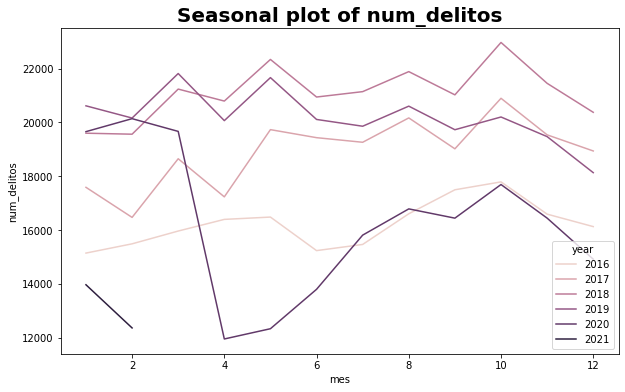

In [57]:
aux = pgr_seasonality.groupby(['year','mes']).sum()[['num_delitos']].reset_index()
fig = plt.figure(figsize=(10,6))
sns.lineplot(aux['mes'], aux['num_delitos'], hue=aux['year'])
plt.title('Seasonal plot of num_delitos', fontsize = 20, loc='center', fontdict=dict(weight='bold'))

/home/abraxas/venv/opi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Seasonal plot of num_delitos')

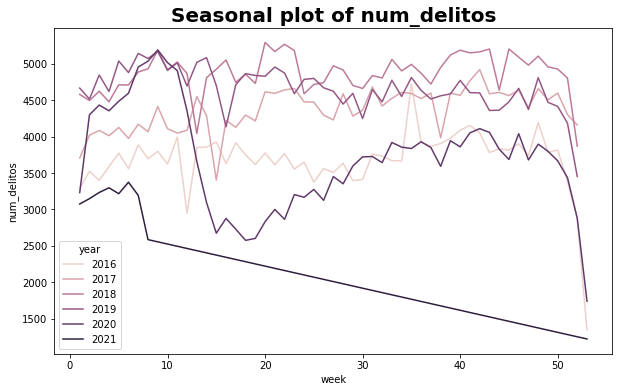

In [58]:
aux = pgr_seasonality.groupby(['year','week']).sum()[['num_delitos']].reset_index()
fig = plt.figure(figsize=(10,6))
sns.lineplot(aux['week'], aux['num_delitos'], hue=aux['year'])
plt.title('Seasonal plot of num_delitos', fontsize = 20, loc='center', fontdict=dict(weight='bold'))

/home/abraxas/venv/opi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Seasonal plot of num_delitos')

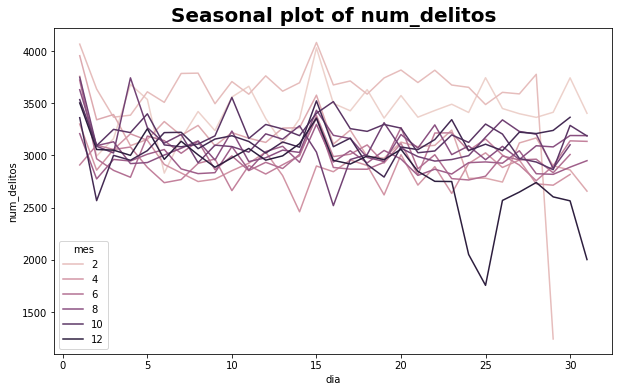

In [59]:
aux = pgr_seasonality.groupby(['mes','dia']).sum()[['num_delitos']].reset_index()
fig = plt.figure(figsize=(10,6))
sns.lineplot(aux['dia'], aux['num_delitos'], hue=aux['mes'])
plt.title('Seasonal plot of num_delitos', fontsize = 20, loc='center', fontdict=dict(weight='bold'))

/home/abraxas/venv/opi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Seasonal plot of num_delitos')

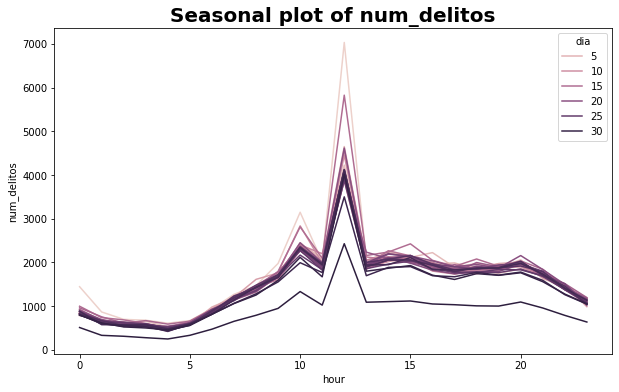

In [60]:
aux = pgr_seasonality.groupby(['dia','hour']).sum()[['num_delitos']].reset_index()
fig = plt.figure(figsize=(10,6))
sns.lineplot(aux['hour'], aux['num_delitos'], hue=aux['dia'])
plt.title('Seasonal plot of num_delitos', fontsize = 20, loc='center', fontdict=dict(weight='bold'))

In [61]:
pgr_seasonality[pgr_seasonality.hour == 11].delito.value_counts(1)

VIOLENCIA FAMILIAR                                                                             0.101058
FRAUDE                                                                                         0.073872
ROBO DE OBJETOS                                                                                0.066469
AMENAZAS                                                                                       0.058714
ROBO A NEGOCIO SIN VIOLENCIA                                                                   0.049898
                                                                                                 ...   
ROBO A NEGOCIO Y VEHICULO SIN VIOLENCIA                                                        0.000017
ROBO A PASAJERO EN ECOBUS CON VIOLENCIA                                                        0.000017
ROBO A TRANSEUNTE EN CINE CON VIOLENCIA                                                        0.000017
ROBO A PASAJERO EN AUTOBUS FORANEO SIN VIOLENCIA                

## ¿Cuáles son los delitos que más caracterizan a cada alcaldía? Es decir, delitos que suceden con mayor frecuencia en una alcaldía y con menor frecuencia en las demás.

In [62]:
pgr_rep_alcaldia = pd.pivot_table(data=pgr[['num_delitos','delito','alcaldia_hechos']],index='delito',columns='alcaldia_hechos',
                                  aggfunc=np.sum).fillna(0)


In [63]:
pgr_rep_alcaldia.columns = [x[1] for x in pgr_rep_alcaldia.columns]

In [64]:
pgr_rep_alcaldia['TOTAL'] = pgr_rep_alcaldia.sum(axis=1)

In [65]:
pgr_rep_alcaldia.drop('nan',axis=1,inplace=True)

In [66]:
columnas = [x for x in pgr_rep_alcaldia.columns if x!='TOTAL']
for col in columnas:
    pgr_rep_alcaldia[col] = pgr_rep_alcaldia[col]/pgr_rep_alcaldia['TOTAL']


In [67]:
pgr_rep_alcaldia.drop('TOTAL',axis=1,inplace=True)

In [68]:
pgr_rep_alcaldia

,ABALA,ACAMBARO,ACAMBAY,ACAPULCO DE JUAREZ,ACATLAN,ACATZINGO,ACAXOCHITLAN,ACAYUCAN,ACOLMAN,ACONCHI,...,ZAPOTLAN DE JUAREZ,ZAPOTLAN EL GRANDE,ZAUTLA,ZEMPOALA,ZIHUATANEJO DE AZUETA,ZINACANTEPEC,ZINAPECUARO,ZITACUARO,ZITLALTEPEC DE TRINIDAD SANCHEZ SANTOS,ZUMPANGO
delito,,,,,,,,,,,,,,,,,,,,,
ABANDONO DE PERSONA,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000421,0.000000,0.0,0.0,0.000000,0.000000
ABORTO,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
ABUSO DE AUTORIDAD,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA PUBLICA,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
ABUSO DE CONFIANZA,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000051,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIOLACION TUMULTUARIA,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
VIOLACION TUMULTUARIA EQUIPARADA,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
VIOLACION TUMULTUARIA EQUIPARADA POR CONOCIDO,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [69]:
dicc = {}
for delito in pgr_rep_alcaldia.index:
    maximo = pgr_rep_alcaldia.loc[delito].max()
    if maximo > 0.5:
        alcaldia = pgr_rep_alcaldia.loc[delito].idxmax(axis = 1, skipna = True)
        if alcaldia in dicc.keys():
            aux = dicc[alcaldia]
            dicc.update({alcaldia:aux+[delito]})
        else:
            dicc[alcaldia] = [delito]

### Respuesta

In [70]:
dicc

{'BENITO JUAREZ': ['ASOCIACION DELICTUOSA', 'CONTAGIO VENERERO'],
 'CUAUHTEMOC': ['CALUMNIAS',
  'COACCION DE SERVIDORES PUBLICOS',
  'DDH FRVT',
  'DDH OFICIO COLABORACION',
  'DELITOS DE ABOGADOS PATRONOS Y LITIGANTES',
  'DESOBEDENCIA DE PARTICULARES',
  'FALSEDAD ANTE AUTORIDADES',
  'FALSEDAD DE DECLARACIONES',
  'ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA',
  'ROBO A PASAJERO EN TREN SUBURBANO CON VIOLENCIA',
  'ROBO A PASAJERO EN TREN SUBURBANO SIN VIOLENCIA',
  'ROBO A PASAJERO EN TROLEBUS CON VIOLENCIA',
  'ROBO A PASAJERO EN TROLEBUS SIN VIOLENCIA',
  'ROBO DE INFANTE',
  'ULTRAJES'],
 'TLAHUAC': ['CONTRA LA LEY GENERAL DE EXPLOSIVOS'],
 'IZTAPALAPA': ['DDH CERESO',
  'ROBO DE VEHICULO Y NOMINA CON VIOLENCIA',
  'ROBO DURANTE TRASLADO DE VALORES (NOMINA) CON VIOLENCIA',
  'VIOLACION A LOS DERECHOS HUMANOS'],
 'GUSTAVO A MADERO': ['DESACATO',
  'LEY FEDERAL DE ARMAS DE FUEGO Y EXPLOSIVOS',
  'UTILIZACION INDEBIDA DE LA VIA PUBLICA'],
 'TLALPAN': ['PROCREACION ASISTIDA'],
 

In [71]:
pgr_rep_alcaldia.loc['ABANDONO DE PERSONA'].idxmax(axis = 1, skipna = True)

'CUAUHTEMOC'

## Calcula el número de homicidios dolosos por cada 100 mil habitantes anual para cada Área Geoestadística Básica (AGEB) del INEGI. (hint: no importa que el dato de población no esté actualizado).

In [72]:
path_u = "data/09_ciudaddemexico/09a.shx"
path_r = "data/09_ciudaddemexico/09ar.shp"

In [73]:
ageb_u = gpd.read_file(path_u)
ageb_r = gpd.read_file(path_r)

In [74]:
ageb_u['tipo'] = 'U'
ageb_r['tipo'] = 'R'

In [75]:
ageb = ageb_u.append(ageb_r).reset_index(drop=True)

<Figure size 720x432 with 0 Axes>

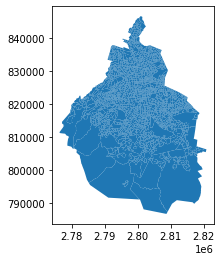

In [76]:
fig = plt.figure(figsize=(10,6))
ageb.plot();

### Sistema de coordenadas

https://stackoverflow.com/questions/31900600/python-and-shapefile-very-large-coordinates-after-importing-shapefile
https://inegi.org.mx/contenidos/productos/prod_serv/contenidos/espanol/bvinegi/productos/nueva_estruc/702825109226.pdf
https://all-geo.org/volcan01010/2012/11/change-coordinates-with-pyproj/

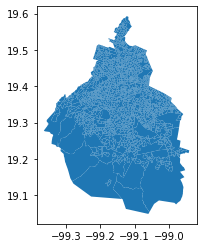

,CVE_ENT,CVE_LOC,CVE_MUN,CVE_AGEB,geometry,tipo,CVEGEO
640,09,0001,006,0626,"POLYGON ((-99.10536 19.38741, -99.10545 19.386...",U,NaN
997,09,0001,007,2117,"POLYGON ((-99.06861 19.30556, -99.06880 19.304...",U,NaN
1690,09,0026,012,1693,"POLYGON ((-99.21462 19.21641, -99.21480 19.216...",U,NaN
408,09,0001,005,2339,"POLYGON ((-99.08178 19.45316, -99.08222 19.452...",U,NaN
567,09,0001,005,1256,"POLYGON ((-99.12843 19.48528, -99.12840 19.485...",U,NaN
253,09,0001,003,1302,"POLYGON ((-99.11513 19.32049, -99.11553 19.320...",U,NaN
2335,09,0001,017,0282,"POLYGON ((-99.10543 19.44006, -99.10550 19.439...",U,NaN
36,09,0001,002,0769,"POLYGON ((-99.15399 19.46921, -99.15339 19.468...",U,NaN
891,09,0001,007,5643,"POLYGON ((-99.04916 19.37881, -99.04793 19.377...",U,NaN
413,09,0001,005,3214,"POLYGON ((-99.12791 19.55139, -99.12777 19.551...",U,NaN


In [77]:
# convert projection to familiar lat/lon
ageb_ = ageb.to_crs('WGS84')

ageb_.plot()
plt.show()
display(ageb_.sample(10))


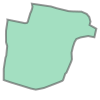

In [78]:
ageb_[ageb_.CVE_AGEB == '0505'].geometry.values[0]

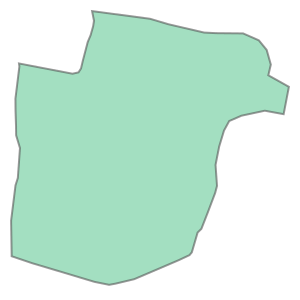

In [79]:
ageb[ageb.CVE_AGEB == '0505'].geometry.values[0]

#### Pruebas Tlalpan

In [80]:
point = Point(longitud,latitud)

NameError: name 'longitud' is not defined

In [113]:
ageb_[ageb_.CVE_AGEB=='0505'].geometry.values[1].contains(point)

NameError: name 'point' is not defined

In [114]:
ageb_[ageb_.CVE_AGEB=='0505'].geometry.values[0].contains(point)

NameError: name 'point' is not defined

## Cambiar sistema de coordenadas

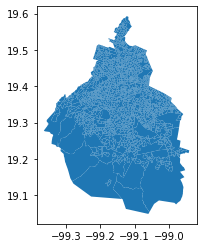

,CVE_ENT,CVE_LOC,CVE_MUN,CVE_AGEB,geometry,tipo,CVEGEO
2099,09,0001,015,0841,"POLYGON ((-99.16000 19.42445, -99.16008 19.424...",U,NaN
1629,09,0001,012,0407,"POLYGON ((-99.16364 19.29090, -99.16400 19.291...",U,NaN
1221,09,0033,009,0488,"POLYGON ((-99.09556 19.20868, -99.09584 19.208...",U,NaN
1242,09,0001,009,0331,"POLYGON ((-99.01828 19.19064, -99.01823 19.190...",U,NaN
1364,09,0001,010,1631,"POLYGON ((-99.24319 19.35401, -99.24333 19.353...",U,NaN
5,09,0001,002,0608,"POLYGON ((-99.21364 19.48094, -99.21336 19.480...",U,NaN
1547,09,0001,011,0359,"POLYGON ((-99.00343 19.27635, -99.00349 19.276...",U,NaN
1150,09,0001,007,433A,"POLYGON ((-99.07334 19.29449, -99.07320 19.294...",U,NaN
2211,09,0001,016,0603,"POLYGON ((-99.17310 19.43609, -99.17273 19.436...",U,NaN
1912,09,0001,014,0882,"POLYGON ((-99.18810 19.37257, -99.18811 19.371...",U,NaN


In [81]:
## convert projection to familiar lat/lon
ageb = ageb.to_crs('WGS84')
ageb.plot()
plt.show()
display(ageb.sample(10))

### AGEB por coordenada

https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

In [82]:
def get_AGEB(coord):
    point = Point(coord[1],coord[2])
    for cve,poligono in zip(ageb.CVE_AGEB,ageb.geometry):
        if poligono.contains(point):
            return (coord[0],cve)


In [83]:
ls_coords = [(i,longitud,latitud) for i,longitud,latitud in zip(range(len(pgr)),pgr.longitud,pgr.latitud)]

start = datetime.now()
pool = multiprocessing.Pool()
r =pool.map(get_AGEB,ls_coords)
end = datetime.now()

In [85]:
print(end-start)

NameError: name 'end' is not defined

In [86]:
r = pickle.load(open('ageb_coords.p','rb'))

In [87]:
len(r)

1168152

In [88]:
aux = [x for x in r if x!= None]

In [89]:
dicc_ageb_id = dict(zip([x[0] for x in aux],[x[1] for x in aux]))

In [90]:
pgr['id_ageb'] = range(len(pgr))

In [91]:
pgr['CVE_AGEB'] = pgr.id_ageb.apply(lambda x: dicc_ageb_id[x] if x in dicc_ageb_id.keys() else 'ND')

#### AGEB/INEGI

In [92]:
inegi = pd.read_csv('data/RESAGEBURB_09TXT10.txt',sep='\t')

inegi = inegi.groupby(['AGEB'])[['POBTOT']].sum().reset_index()

inegi.rename({'AGEB':'CVE_AGEB'},axis=1,inplace=True)

In [93]:
pgr_homdol = pgr[pgr.categoria_delito == 'HOMICIDIO DOLOSO'].copy()

pgr_homdol = pgr_homdol.groupby(['CVE_AGEB','ao_hechos'])[['num_delitos']].sum().reset_index()

pgr_homdol = pgr_homdol.merge(inegi,on='CVE_AGEB')

pgr_homdol['num_hom_100k'] = (pgr_homdol['num_delitos'] / pgr_homdol['POBTOT'])*100000

pgr_homdol = pgr_homdol.merge(ageb[['CVE_AGEB','geometry']],on=['CVE_AGEB'])

pgr_homdol = GeoDataFrame(pgr_homdol)

pgr_homdol = pgr_homdol[pgr_homdol.num_hom_100k != np.math.inf].copy()

### Respuesta 

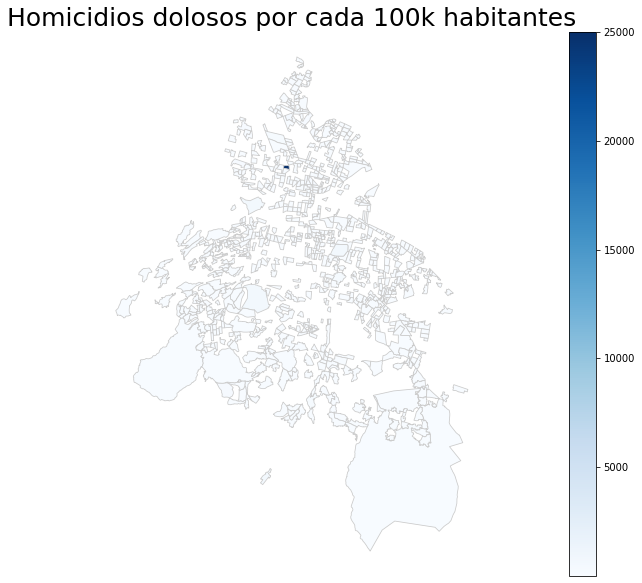

,CVE_AGEB,ao_hechos,num_delitos,POBTOT,num_hom_100k,geometry
138,0057,2016,1,14,7142.857143,"POLYGON ((-99.14849 19.46299, -99.14834 19.462..."
2526,0920,2016,1,414,241.545894,"POLYGON ((-99.11233 19.41711, -99.11241 19.416..."
2274,0798,2016,1,506,197.628458,"POLYGON ((-99.18097 19.42805, -99.18079 19.428..."
2199,0770,2016,1,560,178.571429,"POLYGON ((-99.19022 19.33741, -99.19013 19.336..."
4424,2475,2016,5,2858,174.947516,"POLYGON ((-99.16839 19.13749, -99.17009 19.136..."
4423,2475,2016,5,2858,174.947516,"POLYGON ((-99.08550 19.37912, -99.08461 19.379..."
4712,3375,2016,4,2484,161.030596,"POLYGON ((-99.14337 19.51605, -99.14399 19.515..."
2113,0733,2016,1,664,150.602410,"POLYGON ((-99.14175 19.43626, -99.14209 19.434..."
4315,2297,2016,2,2240,89.285714,"POLYGON ((-99.22390 19.23171, -99.22224 19.231..."
2037,0687,2016,1,1336,74.850299,"POLYGON ((-99.12303 19.42804, -99.12332 19.425..."


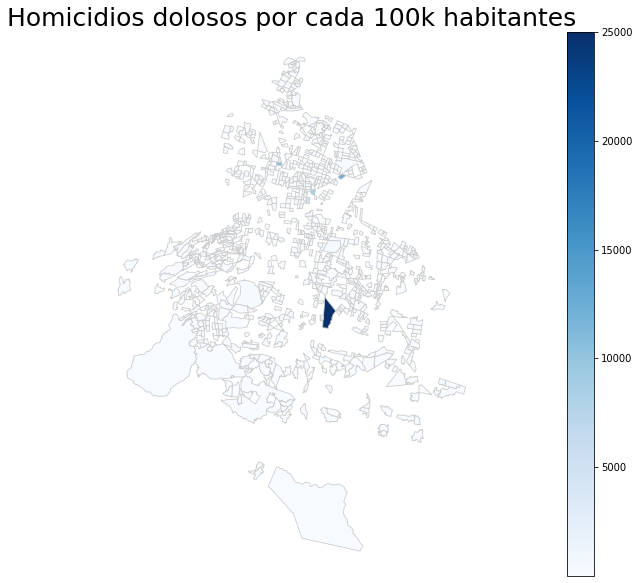

,CVE_AGEB,ao_hechos,num_delitos,POBTOT,num_hom_100k,geometry
3194,1277,2017,2,12,16666.666667,"POLYGON ((-99.09409 19.31287, -99.09394 19.312..."
350,0136,2017,2,24,8333.333333,"POLYGON ((-99.07907 19.44977, -99.07870 19.449..."
139,0057,2017,1,14,7142.857143,"POLYGON ((-99.14849 19.46299, -99.14834 19.462..."
1517,0511,2017,1,18,5555.555556,"POLYGON ((-99.11028 19.43372, -99.11008 19.433..."
2070,0704,2017,2,60,3333.333333,"POLYGON ((-99.11686 19.41984, -99.11701 19.418..."
2200,0770,2017,1,560,178.571429,"POLYGON ((-99.19022 19.33741, -99.19013 19.336..."
2929,112A,2017,1,712,140.449438,"POLYGON ((-99.10194 19.41962, -99.10178 19.419..."
4425,2475,2017,4,2858,139.958013,"POLYGON ((-99.08550 19.37912, -99.08461 19.379..."
4426,2475,2017,4,2858,139.958013,"POLYGON ((-99.16839 19.13749, -99.17009 19.136..."
2563,0945,2017,3,2654,113.036925,"POLYGON ((-99.16443 19.42706, -99.16413 19.426..."


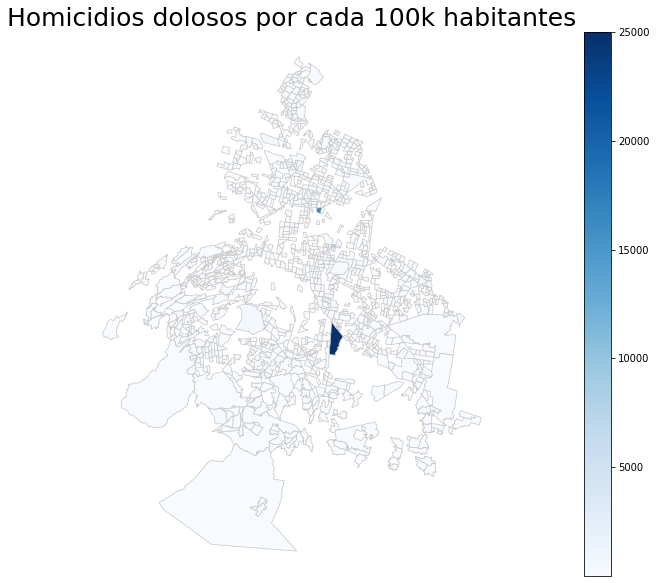

,CVE_AGEB,ao_hechos,num_delitos,POBTOT,num_hom_100k,geometry
3195,1277,2018,1,12,8333.333333,"POLYGON ((-99.09409 19.31287, -99.09394 19.312..."
1518,0511,2018,1,18,5555.555556,"POLYGON ((-99.11028 19.43372, -99.11008 19.433..."
1370,0467,2018,1,34,2941.176471,"POLYGON ((-99.09538 19.39466, -99.09547 19.393..."
3026,1165,2018,2,802,249.376559,"POLYGON ((-99.16737 19.50621, -99.16731 19.506..."
2527,0920,2018,1,414,241.545894,"POLYGON ((-99.11233 19.41711, -99.11241 19.416..."
2201,0770,2018,1,560,178.571429,"POLYGON ((-99.19022 19.33741, -99.19013 19.336..."
1611,0542,2018,10,6026,165.947561,"POLYGON ((-99.15796 19.47361, -99.15806 19.473..."
2372,0834,2018,1,612,163.398693,"POLYGON ((-99.21112 19.43016, -99.21123 19.429..."
2039,0687,2018,2,1336,149.700599,"POLYGON ((-99.12303 19.42804, -99.12332 19.425..."
4443,2507,2018,7,4796,145.954962,"POLYGON ((-99.00295 19.36475, -99.00262 19.364..."


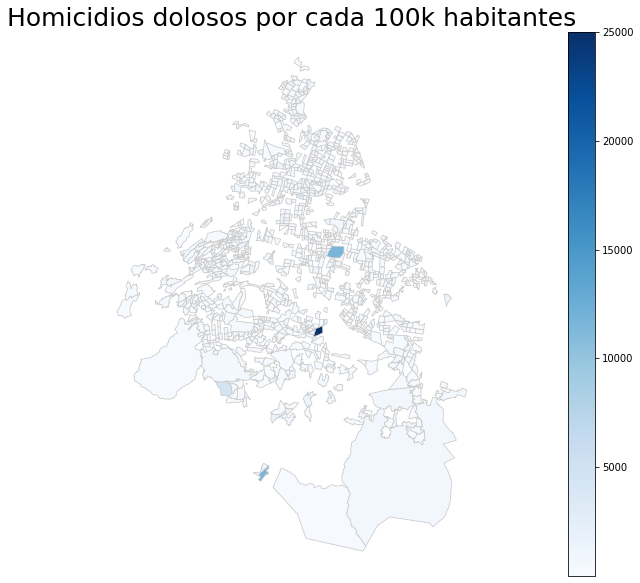

,CVE_AGEB,ao_hechos,num_delitos,POBTOT,num_hom_100k,geometry
3156,1243,2019,1,104,961.538462,"POLYGON ((-99.10612 19.28772, -99.10609 19.285..."
4430,2475,2019,13,2858,454.863541,"POLYGON ((-99.16839 19.13749, -99.17009 19.136..."
4429,2475,2019,13,2858,454.863541,"POLYGON ((-99.08550 19.37912, -99.08461 19.379..."
2359,0825,2019,1,538,185.873606,"POLYGON ((-99.16107 19.37437, -99.16160 19.372..."
4317,2297,2019,4,2240,178.571429,"POLYGON ((-99.22390 19.23171, -99.22224 19.231..."
4921,4999,2019,9,6592,136.529126,"POLYGON ((-99.02667 19.34456, -99.02678 19.342..."
2204,0771,2019,3,2308,129.982669,"POLYGON ((-99.13202 19.43438, -99.13113 19.434..."
4824,4147,2019,1,1002,99.800399,"POLYGON ((-99.07423 19.33353, -99.07424 19.333..."
3364,1395,2019,2,2042,97.943193,"POLYGON ((-99.02494 19.28295, -99.02494 19.281..."
72,0038,2019,4,4880,81.967213,"POLYGON ((-99.12951 19.46265, -99.12919 19.462..."


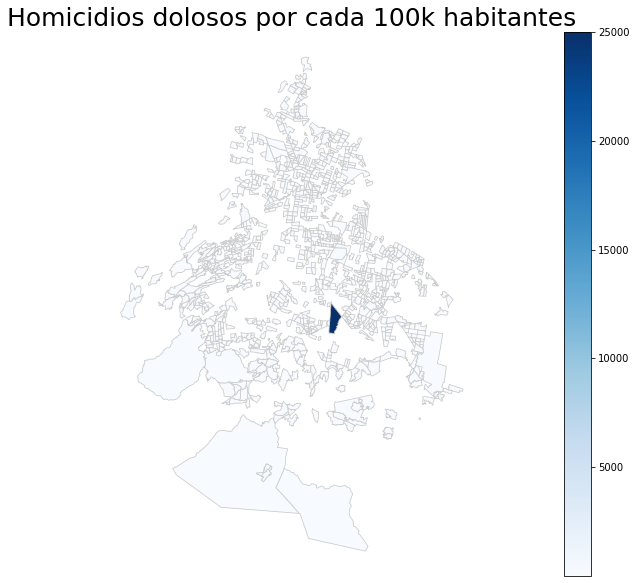

,CVE_AGEB,ao_hechos,num_delitos,POBTOT,num_hom_100k,geometry
3196,1277,2020,3,12,25000.000000,"POLYGON ((-99.09409 19.31287, -99.09394 19.312..."
2102,0729,2020,1,32,3125.000000,"POLYGON ((-99.14935 19.43570, -99.14975 19.435..."
2071,0704,2020,1,60,1666.666667,"POLYGON ((-99.11686 19.41984, -99.11701 19.418..."
2710,1014,2020,2,468,427.350427,"POLYGON ((-99.19705 19.42238, -99.19668 19.422..."
2190,0767,2020,1,474,210.970464,"POLYGON ((-99.13625 19.43343, -99.13644 19.432..."
4432,2475,2020,6,2858,209.937019,"POLYGON ((-99.16839 19.13749, -99.17009 19.136..."
4431,2475,2020,6,2858,209.937019,"POLYGON ((-99.08550 19.37912, -99.08461 19.379..."
2342,0818,2020,1,498,200.803213,"POLYGON ((-99.14109 19.43281, -99.13955 19.432..."
2360,0825,2020,1,538,185.873606,"POLYGON ((-99.16107 19.37437, -99.16160 19.372..."
4318,2297,2020,4,2240,178.571429,"POLYGON ((-99.22390 19.23171, -99.22224 19.231..."


In [94]:
for anio in range(2016,2021):
    ###### create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(30, 10))
    vmin, vmax = min(pgr_homdol.num_hom_100k),max(pgr_homdol.num_hom_100k)
    ###### remove the axis
    ax.axis('off')
    ###### add a title and annotation
    ax.set_title('Homicidios dolosos por cada 100k habitantes', fontdict={'fontsize': '25', 'fontweight' : '3'})
    #ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='######555555')
    ###### Create colorbar legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    ###### empty array for the data range
    sm.set_array([]) ###### or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    ###### add the colorbar to the figure
    fig.colorbar(sm)
    ###### create map
    pgr_homdol[pgr_homdol.ao_hechos == anio].plot(column='num_hom_100k', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    plt.show()
    display(pgr_homdol[pgr_homdol.ao_hechos == anio].sort_values(by='num_hom_100k',ascending=False).head(10))

## ¿Cómo diseñarías un indicador que midiera el nivel “inseguridad”? Diséñalo al nivel de desagregación que te parezca más adecuado (ej. manzana, calle, AGEB, etc.).

El índice corresponde en clasificar 3 niveles la categoría del delito. según sea su gravedad. 
Nos enfocaremos por cada AGEB en métricas a nivel de los 3 niveles:

* índice por cada 100k habitantes
    
    * 10.01>    10  
    * 5.01 - 10 7.5
    * 1.01 - 5  5
    * .5 - 1  2.5
    * 0 - .5 0
 
 **Escalas de arriba en miles**

Aplicar un promedio ponderado a cada nivel de delito: Nivel 3 (50%) Nivel 2 (30%) Nivel 1 (20%) dejando al índice de inseguridad entre 0 - 10 donde 10 es el valor más alto de inseguridad

### Propuesta niveles 

In [95]:
delitos_nivel1 =  ['DELITO DE BAJO IMPACTO','HECHO NO DELICTIVO']
delitos_nivel2 = ['ROBO DE VEHÍCULO CON Y SIN VIOLENCIA',
       'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA','ROBO A NEGOCIO CON VIOLENCIA',
       'ROBO A CASA HABITACIÓN CON VIOLENCIA',
       'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA','ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
       'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
       'ROBO A REPARTIDOR CON Y SIN VIOLENCIA','ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA',
       'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA']
delitos_nivel3 = ['LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO','VIOLACIÓN','HOMICIDIO DOLOSO',
                 'SECUESTRO', 'PLAGIO O SECUESTRO', 'FEMINICIDIO']

In [96]:
pgr['nivel_delito'] = pgr.categoria_delito.apply(lambda x: 'N1' if x in delitos_nivel1
                                                else 'N2' if x in delitos_nivel2
                                                else 'N3' if x in delitos_nivel3
                                                else 'ND')

<AxesSubplot:xlabel='ao_hechos'>

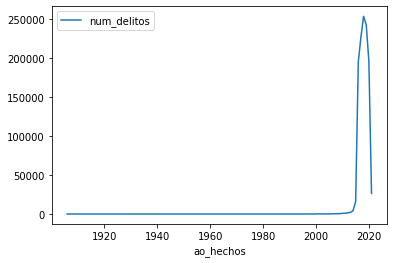

In [97]:
pgr.groupby(['ao_hechos'])[['num_delitos']].sum().plot()

Tomamos apartir de 2010 ya que se va a obtener un promedio anual de número de delitos por cada 100k y apartir de 2005 se tiene un mayor número de registros y además al tener la información del inegi más reciente y no la correspondiente en cada año, al tomar más tiempo incrementa la desviación de la población real en cada año

In [98]:
pgr_indice = pgr[pgr.ao_hechos>=2010].copy()

In [99]:
def indice_inseguridad(info):
    pgr_indice = info[0]
    ageb  = info[1]
    aux = pgr_indice[pgr_indice.CVE_AGEB == ageb][['CVE_AGEB','ao_hechos','nivel_delito','num_delitos',]].copy()
    aux = aux.merge(inegi[['CVE_AGEB','POBTOT']],on='CVE_AGEB')
    aux = aux.groupby(['nivel_delito','ao_hechos']).agg({'num_delitos':'sum','POBTOT':'min'}).reset_index()
    aux['num_100k'] = aux['num_delitos']/aux['POBTOT']*100000
    aux = aux.groupby(['nivel_delito']).agg({'num_100k':'sum'}).reset_index()
    aux['avg_anual_num_100k'] = aux['num_100k']/(2021-2010)
    aux['score'] = [0 if avg<=500 else 2.5 if avg<=2500 else 5 if avg<=5000 else 7.5 if avg<=10 else 10
                   for avg in aux.avg_anual_num_100k]
    aux['inseguridad'] = [score*0.5 if nivel == 'N1' else score*0.3 if nivel == 'N2' else score*0.2 if nivel == 'N3'
                         else np.math.nan for score,nivel in
                         zip(aux.score,aux.nivel_delito)]

    return aux.num_100k.sum(),aux.inseguridad.sum()

In [100]:
cve = pgr_indice.CVE_AGEB.values[0]
resultados = indice_inseguridad((pgr_indice,cve))
print(f'Indice de inseguridad para AGEB {cve} = {resultados[1]}')

Indice de inseguridad para AGEB 0505 = 1.25


## Con alguna de las medidas de crimen que calculaste en los incisos anteriores, encuentra patrones de concentración geográfica de delitos (hint: puedes usar algoritmos de Machine Learning no supervisados). 
11.1. ¿Qué caracteriza a cada punto de concentración de delitos y qué tienen en común?

### Feature engineering

Variables:
    
* dummies para
    * ao_hechos
    * mes_hechos
    * categoria_delito
    * alcaldia_hechos

* fecha_inicio-mes_inicio (mediana)
* num_delitos suma 
* indice inseguridad (promedio)
* num_100k 

In [197]:
pgr_indice[['ao_hechos','mes_hechos']] = pgr_indice[['ao_hechos','mes_hechos']].astype(str)

In [198]:
pgr_dummies = pd.get_dummies(pgr_indice[['ao_hechos','mes_hechos','categoria_delito']])

In [199]:
pgr_dummies

,ao_hechos_2010,ao_hechos_2011,ao_hechos_2012,ao_hechos_2013,ao_hechos_2014,ao_hechos_2015,ao_hechos_2016,ao_hechos_2017,ao_hechos_2018,ao_hechos_2019,...,categoria_delito_ROBO A NEGOCIO CON VIOLENCIA,categoria_delito_ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,categoria_delito_ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,categoria_delito_ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,categoria_delito_ROBO A REPARTIDOR CON Y SIN VIOLENCIA,categoria_delito_ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,categoria_delito_ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,categoria_delito_ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,categoria_delito_SECUESTRO,categoria_delito_VIOLACIÓN
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1168148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1168149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1168150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
pgr_dummies['CVE_AGEB'] = pgr_indice['CVE_AGEB']

In [201]:
len(pgr_dummies)

1164994

In [206]:
#Dummies
pgr_dummies = pgr_dummies.groupby(['CVE_AGEB']).sum().reset_index()

In [105]:
#Tiempo transcurrido para abrir una carpeta de investigación
pgr_indice['tiempo_investigacion'] = (pgr_indice['fecha_inicio'].dt.date-pgr_indice['fecha_hechos'].dt.date).dt.days

In [106]:
#TAD
pgr_ageb = pgr_indice.groupby(['CVE_AGEB']).agg({'tiempo_investigacion':'mean','num_delitos':'sum'}).reset_index()

In [107]:
#Integrando dummies
pgr_ageb = pgr_ageb.merge(pgr_dummies,on='CVE_AGEB')

In [108]:
#POblación total
pgr_ageb = pgr_ageb.merge(inegi[['CVE_AGEB','POBTOT']],on='CVE_AGEB')

In [109]:
ls_agebs = list(pgr_ageb.CVE_AGEB.unique())
i=0
dicc = {}
for cve in ls_agebs:
    i+=1
    num_100k,inseguridad = indice_inseguridad((pgr_indice,cve))
    dicc[cve] = {'num_100k':num_100k,'inseguridad':inseguridad}
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949


In [110]:
pgr_ageb['num_100k'] = pgr_ageb['CVE_AGEB'].apply(lambda x: dicc[x]['num_100k'])
pgr_ageb['inseguridad'] = pgr_ageb['CVE_AGEB'].apply(lambda x: dicc[x]['inseguridad'])

In [210]:
ls_vars = [x for x in pgr_ageb.columns if x!='CVE_AGEB']

### Limpieza de datos

In [212]:
pgr_ageb = pgr_ageb[(pgr_ageb.num_100k != np.math.inf) & (pgr_ageb.num_100k != np.math.nan)].copy()

In [213]:
pgr_ageb.describe()

,tiempo_investigacion,POBTOT,num_100k,inseguridad,ao_hechos_2010,ao_hechos_2011,ao_hechos_2012,ao_hechos_2013,ao_hechos_2014,ao_hechos_2015,...,categoria_delito_ROBO A NEGOCIO CON VIOLENCIA,categoria_delito_ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,categoria_delito_ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,categoria_delito_ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,categoria_delito_ROBO A REPARTIDOR CON Y SIN VIOLENCIA,categoria_delito_ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA,categoria_delito_ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,categoria_delito_ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,categoria_delito_SECUESTRO,categoria_delito_VIOLACIÓN
count,1936.000000,1936.000000,1.936000e+03,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,...,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000
mean,35.522321,9101.357438,2.147864e+04,0.564050,0.398760,0.448864,0.668388,0.975723,1.977789,7.722107,...,10.033058,2.012913,0.565083,5.532541,6.098140,34.179752,0.293388,31.388946,0.089360,2.324897
std,22.230197,5916.198188,2.050166e+05,1.127627,1.484834,1.913226,2.824872,3.891544,7.191872,17.525832,...,11.879583,3.682536,1.020665,29.778128,9.370341,39.057682,1.785580,26.254490,0.316261,2.408495
min,0.333333,2.000000,9.990010e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.196402,4754.000000,3.232353e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,11.000000,0.000000,12.000000,0.000000,1.000000
50%,31.326616,7898.000000,4.960897e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,...,6.000000,1.000000,0.000000,0.000000,4.000000,24.000000,0.000000,26.000000,0.000000,2.000000
75%,40.902878,12302.500000,8.078614e+03,1.250000,0.000000,0.000000,1.000000,1.000000,2.000000,9.000000,...,14.000000,2.000000,1.000000,0.000000,8.000000,44.000000,0.000000,44.000000,0.000000,3.000000
max,334.850842,40848.000000,5.650000e+06,10.000000,40.000000,46.000000,77.000000,104.000000,179.000000,417.000000,...,112.000000,57.000000,13.000000,456.000000,285.000000,404.000000,65.000000,353.000000,3.000000,19.000000


In [215]:
iso = IsolationForest(max_features=2,contamination=0.05)

In [216]:
iso.fit(pgr_ageb[ls_vars])

IsolationForest(contamination=0.05, max_features=2)

In [217]:
outliers = iso.predict(pgr_ageb[ls_vars])

In [218]:
X = pgr_ageb[outliers!=-1].copy()

In [249]:
def iqr_outliers(df,columna,qup=0.75,qdown=0.25,fact=1.5):
    qup_value = df[columna].quantile(qup)
    qdown_value = df[columna].quantile(qdown)
    iqr = qup_value-qdown_value
    df = df[(df[columna]>=qdown_value-fact*iqr) & (df[columna]<=qup_value+fact*iqr)]
    return df

In [250]:
X = iqr_outliers(pgr_ageb,'num_100k')

In [252]:
X[ls_vars].describe()

,num_100k,inseguridad
count,1744.000000,1744.000000
mean,5276.516127,0.327552
std,3033.125871,0.549839
min,99.900100,0.000000
25%,3101.342350,0.000000
50%,4545.508251,0.000000
75%,6848.518556,1.250000
max,15344.603381,1.250000


## Reducción de dimensiones

In [253]:
X[ls_vars].describe()

,num_100k,inseguridad
count,1744.000000,1744.000000
mean,5276.516127,0.327552
std,3033.125871,0.549839
min,99.900100,0.000000
25%,3101.342350,0.000000
50%,4545.508251,0.000000
75%,6848.518556,1.250000
max,15344.603381,1.250000


In [254]:
ls_vars = ['num_100k','inseguridad']

In [255]:
pca = PCA(n_components=2, random_state=42)

In [256]:
pca.fit(X[ls_vars])

PCA(n_components=2, random_state=42)

In [257]:
pca.explained_variance_ratio_

array([9.99999989e-01, 1.13005123e-08])

In [260]:
Xp = pd.DataFrame(pca.transform(pgr_ageb[ls_vars]),columns=['p1','p2'])

<AxesSubplot:xlabel='p1', ylabel='p2'>

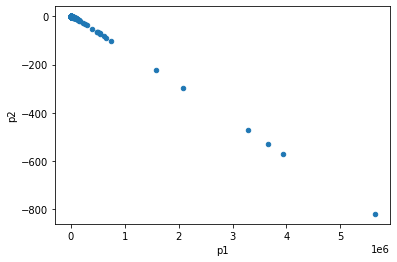

In [261]:
Xp.plot(kind='scatter',x='p1',y='p2')

### Clusters

In [262]:
sse,db,slc = {}, {}, {}
for k in range(2, 10):
    print(k)
    mini_Xp = Xp.sample(frac=0.1)
    kmeans = KMeans(n_clusters=k, random_state=10).fit(mini_Xp)
    if k == 3: 
        labels = kmeans.labels_
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_

2
3
4
5
6
7
8
9


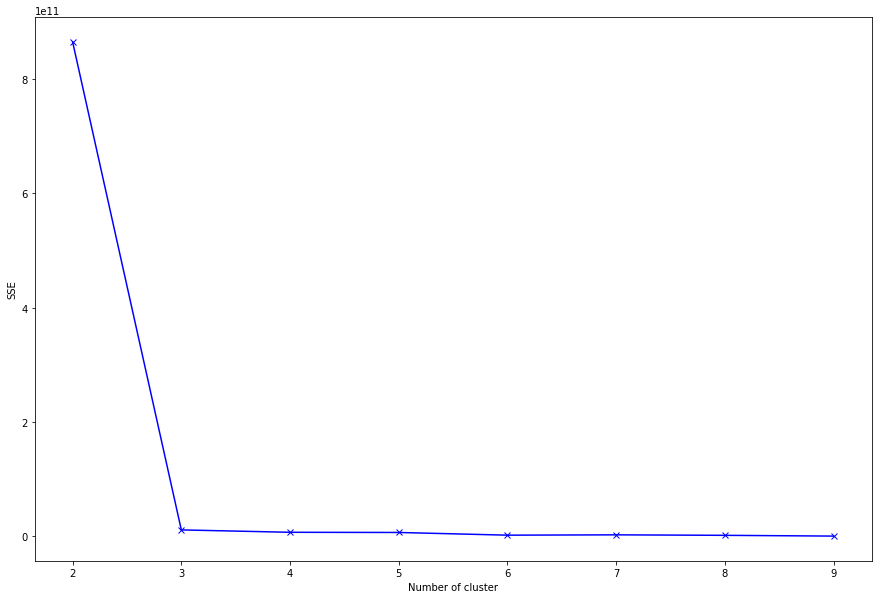

In [263]:
plt.figure(figsize=(15,10))
plt.plot(list(sse.keys()), list(sse.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [264]:
km = KMeans(n_clusters=3,random_state=3)

In [265]:
km.fit(X[ls_vars])

KMeans(n_clusters=3, random_state=3)

In [266]:
X['km'] = km.predict(X[ls_vars])

<ipython-input-266-e34fad23cd0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['km'] = km.predict(X[ls_vars])


In [267]:
X['km'].value_counts(1)

0    0.515482
1    0.351491
2    0.133028
Name: km, dtype: float64

In [268]:
X[ls_vars+['km']].groupby(['km']).mean()

,num_100k,inseguridad
km,,
0,3002.724965,0.000000
1,6378.828083,0.458809
2,11174.882611,1.250000


* Cluster 0: Seguros
* CLuster 1: Inseguro
* Cluster 2: Peligroso

In [272]:
ageb_concentracion = X.merge(ageb[['CVE_AGEB','geometry']],on='CVE_AGEB')[['km','geometry','CVE_AGEB']]

In [274]:
ageb_concentracion = GeoDataFrame(ageb_concentracion)

### Respuesta

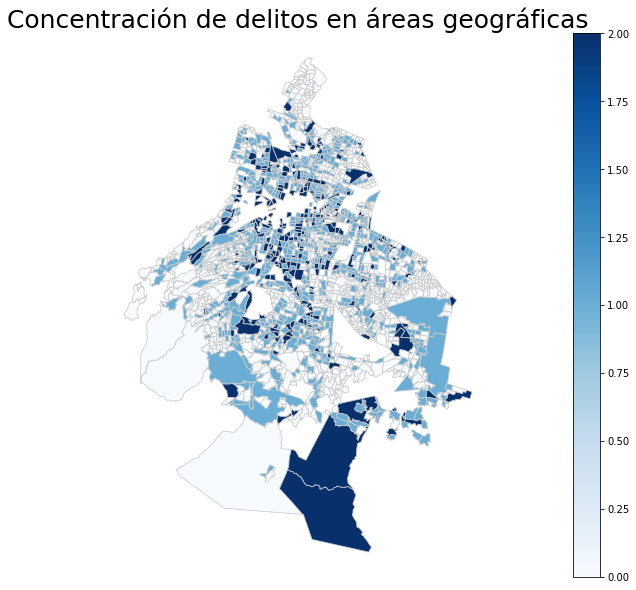

,num_100k,inseguridad
km,,
0,3002.724965,0.000000
1,6378.828083,0.458809
2,11174.882611,1.250000


In [288]:
###### create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
vmin, vmax = 0,2
###### remove the axis
ax.axis('off')
###### add a title and annotation
ax.set_title('Concentración de delitos en áreas geográficas', fontdict={'fontsize': '25', 'fontweight' : '3'})
#ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='######555555')
###### Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
###### empty array for the data range
sm.set_array([]) ###### or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
###### add the colorbar to the figure
fig.colorbar(sm)
###### create map
ageb_concentracion.plot(column='km', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
plt.show()
display(X[ls_vars+['km']].groupby(['km']).mean())

Hay una alta concentración de delitos peligrosos en el sur 

##  Toma los delitos clasificados como “Robo a pasajero a bordo de transporte público con y sin violencia”. ¿Cuáles son las ruta de transporte público donde más ocurren estos delitos?

In [295]:
path_rutasCDMX = "data//rutasCDMX.csv"

In [297]:
df_rutas_cdmx = pd.read_csv(path_rutasCDMX)

In [305]:
def getPolygon(StringListCords):
    # Converting string to list
    try:
        res = StringListCords.strip(')(').split(' 0,')
        listCords = [(lambda x: ( float(x.split(' ')[0]) ,float(x.split(' ')[1]) ) )(x) for x in res]
        return Polygon(listCords)
        
    except Exception as e:
        print("*"*10)
        print(StringListCords)
        print(e)
        return None

def getStringList(value):
    return re.search("(?<=MULTILINESTRING Z )[\W\d\\(\\)]+",value).group()
def get_ruta(coord):
    point = Point(coord[1],coord[2])
    for ruta,poligono in zip(df_rutas_cdmx_geo.RUTA,df_rutas_cdmx_geo.geometry):
        try:
            if poligono.contains(point):
                return (ruta)
        except Exception as e:
            pass
        
def getDf_Robo_Trans_Pub(df_pgr_param:DataFrame,df_rutas_param,columnName):
    df_pgr = df_pgr_param[df_pgr_param[columnName].str.contains('ROBO A PASAJERO A BORDO DE TRANSPORTE') ]
    
    ls_coords = [(i,longitud,latitud) for i,longitud,latitud in zip(range(len(df_pgr)),df_pgr.longitud,df_pgr.latitud)]
    
    start = datetime.now()
    pool = multiprocessing.Pool()
    r = pool.map(get_ruta,ls_coords )
    df_pgr["ruta"] = r
    
    end = datetime.now()
    
    return df_pgr

In [298]:
df_rutas_cdmx["StringListValueCord"] = df_rutas_cdmx.WKT.apply(lambda x: getStringList(x))

In [301]:
df_rutas_cdmx["geometry"] = df_rutas_cdmx.StringListValueCord.apply(lambda x: getPolygon(x))

**********
((-99.1531904938271 19.4392273797664 0,-99.153889217065 19.4373874942832 0))
A LinearRing must have at least 3 coordinate tuples
**********
((-99.1136066456737 19.4876721730308 0,-99.1139746532473 19.4868573486457 0))
A LinearRing must have at least 3 coordinate tuples
**********
((-99.126427 19.544771 0,-99.141959 19.540266 0))
A LinearRing must have at least 3 coordinate tuples


In [303]:
df_rutas_cdmx_geo = GeoDataFrame(df_rutas_cdmx)

In [306]:
df_pgr_rutas = getDf_Robo_Trans_Pub(pgr, df_rutas_cdmx_geo,'delito').dropna(subset=["ruta"])

<ipython-input-305-7633b9e6aa54>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pgr["ruta"] = r


### Respuesta

In [307]:
df_pgr_rutas.groupby(["ruta"])[["delito"]].count().rename(columns={"delito":"TotalDelitos"}).sort_values(by=["TotalDelitos"],ascending=False).head(10)

,TotalDelitos
ruta,
Canal de Garay - Toreo,687
Chapultepec - Av. 602,532
Campestre Potrero - Metro Zaragoza/Metro Tepalcates,302
Villa Milpa Alta - Metro Tasqueña/Tlahuac,286
Santa Catarina - Metro Constitucion de 1917,271
Chapultepec - C. de Abastos,247
Metro Santa Martha - Metro Mixcoac,215
Metro Mixcoac - Metro Santa Martha,174
Col. El Tepetatal (El Charco) - Metro La Raza,145
